# Object Detection Demo
Welcome to the object detection inference walkthrough!  This notebook will walk you step by step through the process of using a pre-trained model to detect objects in an image. Make sure to follow the [installation instructions](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/installation.md) before you start.

# Imports

In [1]:
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image

# This is needed since the notebook is stored in the object_detection folder.
sys.path.append("..")


if tf.__version__ < '1.4.0':
  raise ImportError('Please upgrade your tensorflow installation to v1.4.* or later!')

## Env setup

In [2]:
# This is needed to display the images.
%matplotlib inline

## Object detection imports
Here are the imports from the object detection module.

# Model preparation 

## Variables

Any model exported using the `export_inference_graph.py` tool can be loaded here simply by changing `PATH_TO_CKPT` to point to a new .pb file.  

By default we use an "SSD with Mobilenet" model here. See the [detection model zoo](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/detection_model_zoo.md) for a list of other models that can be run out-of-the-box with varying speeds and accuracies.

In [3]:
# What model to download.
MODEL_NAME = 'ssd_mobilenet_v1_coco_2017_11_17'
MODEL_FILE = MODEL_NAME + '.tar.gz'
DOWNLOAD_BASE = 'http://download.tensorflow.org/models/object_detection/'

# Path to frozen detection graph. This is the actual model that is used for the object detection.
PATH_TO_CKPT = MODEL_NAME + '/frozen_inference_graph.pb'

# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = os.path.join('data', 'mscoco_label_map.pbtxt')

NUM_CLASSES = 90

## Download Model

In [4]:
opener = urllib.request.URLopener()
opener.retrieve(DOWNLOAD_BASE + MODEL_FILE, MODEL_FILE)
tar_file = tarfile.open(MODEL_FILE)
for file in tar_file.getmembers():
  file_name = os.path.basename(file.name)
  if 'frozen_inference_graph.pb' in file_name:
    tar_file.extract(file, os.getcwd())

## Load a (frozen) Tensorflow model into memory.

In [5]:
detection_graph = tf.Graph()
with detection_graph.as_default():
  od_graph_def = tf.GraphDef()
  with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
    serialized_graph = fid.read()
    od_graph_def.ParseFromString(serialized_graph)
    tf.import_graph_def(od_graph_def, name='')
    
    

In [6]:
def convert_label_map_to_categories(label_map,
                                    max_num_classes,
                                    use_display_name=True):
  """Loads label map proto and returns categories list compatible with eval.
  This function loads a label map and returns a list of dicts, each of which
  has the following keys:
    'id': (required) an integer id uniquely identifying this category.
    'name': (required) string representing category name
      e.g., 'cat', 'dog', 'pizza'.
  We only allow class into the list if its id-label_id_offset is
  between 0 (inclusive) and max_num_classes (exclusive).
  If there are several items mapping to the same id in the label map,
  we will only keep the first one in the categories list.
  Args:
    label_map: a StringIntLabelMapProto or None.  If None, a default categories
      list is created with max_num_classes categories.
    max_num_classes: maximum number of (consecutive) label indices to include.
    use_display_name: (boolean) choose whether to load 'display_name' field
      as category name.  If False or if the display_name field does not exist,
      uses 'name' field as category names instead.
  Returns:
    categories: a list of dictionaries representing all possible categories.
  """
  categories = []
  list_of_ids_already_added = []
  if not label_map:
    label_id_offset = 1
    for class_id in range(max_num_classes):
      categories.append({
          'id': class_id + label_id_offset,
          'name': 'category_{}'.format(class_id + label_id_offset)
      })
    return categories
  for item in label_map.item:
    if not 0 < item.id <= max_num_classes:
      logging.info('Ignore item %d since it falls outside of requested '
                   'label range.', item.id)
      continue
    if use_display_name and item.HasField('display_name'):
      name = item.display_name
    else:
      name = item.name
    if item.id not in list_of_ids_already_added:
      list_of_ids_already_added.append(item.id)
      categories.append({'id': item.id, 'name': name})
  return categories


## Loading label map
Label maps map indices to category names, so that when our convolution network predicts `5`, we know that this corresponds to `airplane`.  Here we use internal utility functions, but anything that returns a dictionary mapping integers to appropriate string labels would be fine

In [7]:
from PIL import Image, ImageDraw

from skimage import transform

In [8]:
from skimage import io

In [9]:
with open('mscoco_label_map.pbtxt') as file:  
    data = file.read() 
    
categories = [data.split('display_name')[i+1].split('"')[1] for i in range(len(  data.split('display_name')) - 1 )]

In [ ]:
indices = [int(data.split('id')[i+1].split(': ')[1].split('\n')[0]) for i in range(len(  data.split('display_name')) - 1 )]

In [10]:
categ

## Helper code

In [11]:
def load_image_into_numpy_array(image):
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

# Detection

In [12]:
def run_inference_for_single_image(image, graph):
  with graph.as_default():
    with tf.Session() as sess:
      # Get handles to input and output tensors
      ops = tf.get_default_graph().get_operations()
      all_tensor_names = {output.name for op in ops for output in op.outputs}
      tensor_dict = {}
      for key in [
          'num_detections', 'detection_boxes', 'detection_scores',
          'detection_classes', 'detection_masks'
      ]:
        tensor_name = key + ':0'
        if tensor_name in all_tensor_names:
          tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
              tensor_name)
      if 'detection_masks' in tensor_dict:
        # The following processing is only for single image
        detection_boxes = tf.squeeze(tensor_dict['detection_boxes'], [0])
        detection_masks = tf.squeeze(tensor_dict['detection_masks'], [0])
        # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
        real_num_detection = tf.cast(tensor_dict['num_detections'][0], tf.int32)
        detection_boxes = tf.slice(detection_boxes, [0, 0], [real_num_detection, -1])
        detection_masks = tf.slice(detection_masks, [0, 0, 0], [real_num_detection, -1, -1])
        detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
            detection_masks, detection_boxes, image.shape[0], image.shape[1])
        detection_masks_reframed = tf.cast(
            tf.greater(detection_masks_reframed, 0.5), tf.uint8)
        # Follow the convention by adding back the batch dimension
        tensor_dict['detection_masks'] = tf.expand_dims(
            detection_masks_reframed, 0)
      image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

      # Run inference
      output_dict = sess.run(tensor_dict,
                             feed_dict={image_tensor: np.expand_dims(image, 0)})

      # all outputs are float32 numpy arrays, so convert types as appropriate
      output_dict['num_detections'] = int(output_dict['num_detections'][0])
      output_dict['detection_classes'] = output_dict[
          'detection_classes'][0].astype(np.uint8)
      output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
      output_dict['detection_scores'] = output_dict['detection_scores'][0]
      if 'detection_masks' in output_dict:
        output_dict['detection_masks'] = output_dict['detection_masks'][0]
  return output_dict

In [57]:
# For the sake of simplicity we will use only 2 images:
# image1.jpg
# image2.jpg
# If you want to test the code with your images, just add path to the images to the TEST_IMAGE_PATHS.
PATH_TO_TEST_IMAGES_DIR = '/home/impett/Documents/esu2018/ImageData/all cards//'
TEST_IMAGE_PATHS = PATH_TO_TEST_IMAGES_DIR + '6.лицевая.jpg' 



# TEST_IMAGE_PATHS = 'https://images.robertharding.com/preview/RM/RH/HORIZONTAL/1161-4342.jpg'


# Size, in inches, of the output images.
IMAGE_SIZE = (12, 8)

In [58]:
image = io.imread(TEST_IMAGE_PATHS)
output_dict = run_inference_for_single_image(image, detection_graph)

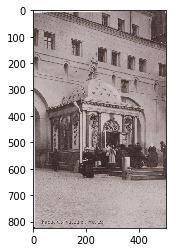

In [59]:
plt.imshow(image)

[0.58662343 0.5735006  0.50413334 0.4720388  0.42057934]


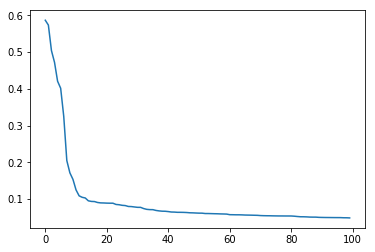

In [60]:
plt.plot(output_dict['detection_scores'])
print(output_dict['detection_scores'][:5])

In [61]:
maxDetection = np.nonzero(output_dict['detection_scores'] < 0.1)[0][0]

In [62]:
maxDetection

14

[0.5964081  0.53056455 0.77933407 0.6680342 ]


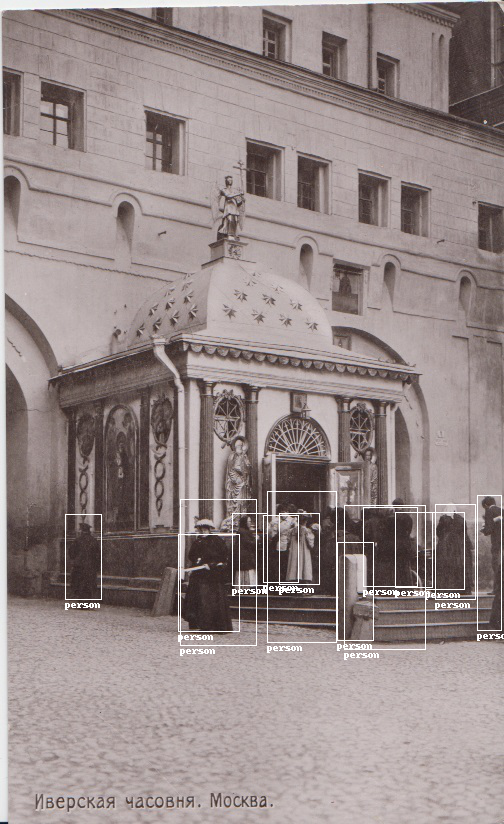

In [63]:
ii = 0
im = Image.fromarray(np.uint8(image),'RGB')

draw = ImageDraw.Draw(im)
for ii in range(maxDetection):
    box =  output_dict['detection_boxes'][ii].copy()
    box2 = box.copy()
    box2[0] = box[1]*im.width
    box2[1] = box[0]*im.height
    box2[2] = box[3]*im.width
    box2[3] = box[2]*im.height
    draw.rectangle(box2,outline='white')
    draw.text((box2[0], box2[3]), 
             categories[np.nonzero(indices==output_dict['detection_classes'][ii])[0][0]])
del draw
print(box)
im

In [ ]:
with detection_graph.as_default():
    with tf.Session() as sess:
      # Get handles to input and output tensors
      ops = tf.get_default_graph().get_operations()
      all_tensor_names = {output.name for op in ops for output in op.outputs}
      tensor_dict = {}
      for key in [
          'num_detections', 'detection_boxes', 'detection_scores',
          'detection_classes', 'detection_masks'
      ]:
        tensor_name = key + ':0'
        if tensor_name in all_tensor_names:
          tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
              tensor_name)
        
        
        
      if 'detection_masks' in tensor_dict:
        # The following processing is only for single image
        detection_boxes = tf.squeeze(tensor_dict['detection_boxes'], [0])
        detection_masks = tf.squeeze(tensor_dict['detection_masks'], [0])
        # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
        real_num_detection = tf.cast(tensor_dict['num_detections'][0], tf.int32)
        detection_boxes = tf.slice(detection_boxes, [0, 0], [real_num_detection, -1])
        detection_masks = tf.slice(detection_masks, [0, 0, 0], [real_num_detection, -1, -1])
        detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
            detection_masks, detection_boxes, image.shape[0], image.shape[1])
        detection_masks_reframed = tf.cast(
            tf.greater(detection_masks_reframed, 0.5), tf.uint8)
        # Follow the convention by adding back the batch dimension
        tensor_dict['detection_masks'] = tf.expand_dims(
            detection_masks_reframed, 0)
      image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

#       # Run inference
      output_dict = sess.run(tensor_dict,
                             feed_dict={image_tensor: np.expand_dims(image, 0)})
    

In [ ]:
tf.get_default_graph().get_tensor_by_name('image_tensor:0')

In [378]:
all_tensor_names

{'Postprocessor/BatchMultiClassNonMaxSuppression/map/while/MultiClassNonMaxSuppression/ClipToWindow_67/split:3',
 'Postprocessor/BatchMultiClassNonMaxSuppression/map/while/MultiClassNonMaxSuppression/ClipToWindow_52/unstack:1',
 'Postprocessor/BatchMultiClassNonMaxSuppression/map/while/MultiClassNonMaxSuppression/ClipToWindow_50/Area/mul:0',
 'Postprocessor/BatchMultiClassNonMaxSuppression/map/while/MultiClassNonMaxSuppression/ClipToWindow_78/Area/split:2',
 'Postprocessor/BatchMultiClassNonMaxSuppression/map/while/MultiClassNonMaxSuppression/FilterGreaterThan_80/Cast:0',
 'Postprocessor/BatchMultiClassNonMaxSuppression/map/while/MultiClassNonMaxSuppression/Gather_53/Gather_2:0',
 'Postprocessor/BatchMultiClassNonMaxSuppression/map/while/MultiClassNonMaxSuppression/Slice_36/begin:0',
 'Postprocessor/BatchMultiClassNonMaxSuppression/map/while/MultiClassNonMaxSuppression/ClipToWindow_74/split/split_dim:0',
 'Postprocessor/BatchMultiClassNonMaxSuppression/map/while/MultiClassNonMaxSuppres

In [370]:
#       # all outputs are float32 numpy arrays, so convert types as appropriate
#       output_dict['num_detections'] = int(output_dict['num_detections'][0])
#       output_dict['detection_classes'] = output_dict[
#           'detection_classes'][0].astype(np.uint8)
#       output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
#       output_dict['detection_scores'] = output_dict['detection_scores'][0]
#       if 'detection_masks' in output_dict:
#         output_dict['detection_masks'] = output_dict['detection_masks'][0]
    